In [4]:
import numpy as np
from keras.datasets import boston_housing
from keras import models, layers

In [ ]:
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [8]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data_std = train_data / std

test_data -= mean
test_data_std = test_data / std

In [5]:
def build_model():
    network = models.Sequential()
    network.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
    network.add(layers.Dense(64, activation='relu'))
    network.add(layers.Dense(1))
    network.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return network

In [9]:
k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

for i in range(k):
    print('processing fold #', i)
    val_data_std = train_data_std[i*num_val_samples : (i+1)*num_val_samples]
    val_targets = train_targets[i*num_val_samples : (i+1)*num_val_samples]

    partial_train_data_std = np.concatenate(
        [train_data_std[:i*num_val_samples],
         train_data_std[(i+1)*num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i*num_val_samples],
         train_targets[(i+1)*num_val_samples:]],
        axis=0)
    network = build_model()
    network.fit(partial_train_data_std, partial_train_targets,
                epochs=num_epochs,
                batch_size=1, verbose=0)        # verbose = 0, quiet mode
    val_mse, val_mae = network.evaluate(val_data_std, val_targets, verbose=0)
    all_scores.append(val_mae)

processing fold # 0


processing fold # 1


processing fold # 2


processing fold # 3


In [12]:
print(np.array(all_scores).mean())

2.480109453201294


平均绝对误差的平均值更能代表模型的评估结果, 平均绝对误差的平均值为2.48

In [21]:
# 使用history记录模型在每一轮的表现
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('processing fold #', i)
    val_data_std = train_data_std[i*num_val_samples : (i+1)*num_val_samples]
    val_targets = train_targets[i*num_val_samples : (i+1)*num_val_samples]

    partial_train_data_std = np.concatenate(
        [train_data_std[:i*num_val_samples],
         train_data_std[(i+1)*num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i*num_val_samples],
         train_targets[(i+1)*num_val_samples:]],
        axis=0)
    network = build_model()
    history = network.fit(partial_train_data_std, partial_train_targets,
                epochs=num_epochs, validation_data=(val_data_std, val_targets),
                batch_size=1, verbose=0)        # verbose = 0, quiet mode
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

processing fold # 0


processing fold # 1


processing fold # 2


processing fold # 3


In [23]:
# 求每个轮次中的K折交叉验证分数平均值
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

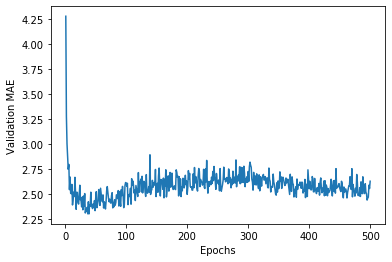

In [24]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history)+1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

因为纵轴的数据范围大, 数据方差较大, 可删除前10个数据点, 因为他们的取值与其它数据相差较大
同时将每个数据点替换为前面数据点的指数移动平均值,以得到它的光滑曲线

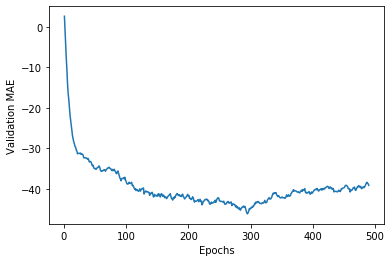

In [25]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous*factor + point*(1-point))
        else:
            smoothed_points.append(point)

    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])
plt.plot(range(1, len(smooth_mae_history)+1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

从途中可以看出, 平均绝对误差在290轮之后不再降低,反而逐渐增大, 开始过拟合.
重新编译一个模型, 并在所有训练数据上训练

In [27]:
num_epochs = 290
network = build_model()
network.fit(train_data_std, train_targets,
            epochs=num_epochs,
            batch_size=32, verbose=0)

test_mse_score, test_mae_score = network.evaluate(test_data_std, test_targets)
print(test_mae_score)

1/4 [======>.......................] - ETA: 0s - loss: 6.1115 - mae: 2.1107

4/4 [==============================] - 0s 545us/step - loss: 12.3303 - mae: 2.4151


2.4151055812835693


最终得到的平均绝对误差为2.4, 预测的房价和实际价格相差约2400美元